In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import itertools

from model import PolynomialActivation
from train import fit_activation
from utils import get_max_firing_rate
from data import load_data, preprocess_data

In [2]:
def get_activation_plot(actv, start=-100, end=270):
    currents = torch.linspace(start, end, steps=300)
    fs = []
    with torch.no_grad():
        for i in currents:
            f = actv(i)
            fs.append(f)
    return currents, fs

def plot_activation(Is, fs, actv, loss):
    fig, axs = plt.subplots(2)
    fig.suptitle(f"id={cell_id}, bin={bin_size}, deg={actv.degree}, loss={loss}, C={actv.C}")
    axs[0].scatter(Is, fs)
    axs[1].scatter(Is, fs)
    xs1, ys1 = get_activation_plot(actv, end=int(actv.max_current)+10)
    xs2, ys2 = get_activation_plot(actv, end=1000)
    axs[0].plot(xs1, ys1)
    axs[1].plot(xs2, ys2)
    
def get_activations(
    Is, 
    fs, 
    cell_id, 
    bin_size, 
    epochs=1000, 
    max_degree=3, 
    repeats=3, 
    save_losses=True, 
    save_plot=True,
    C=0.1,
    max_firing_rate=0.2,
    loss_fn="huber"
):
    max_current = np.max(np.abs(Is.numpy()))
    actvs = []
    losses = []

    for degree in range(1, max_degree+1):
        print(f"Degree {degree}")
        best_actv = None
        best_loss = 1e10
        
        for i in range(repeats):
            print(f"Trial {i+1}")
            actv = PolynomialActivation()
            actv.init_params(degree, max_current, max_firing_rate, Is, fs, C=C)
            actv.bin_size = bin_size
            if loss_fn == "huber":
                criterion = torch.nn.HuberLoss()
            elif loss_fn == "poisson":
                criterion = torch.nn.PoissonNLLLoss(log_input=False)
            optimizer = torch.optim.Adam(actv.parameters(), lr=0.05)

            ls = fit_activation(
                actv,
                criterion,
                optimizer,
                Is,
                fs,
                epochs=epochs,
                C=C,
                loss_fn=loss_fn
            )
            
            loss = ls[-1]
            
            if save_losses:
                plt.plot(list(range(len(ls))), np.log(ls))
                plt.title(f"cell_id={cell_id}, bin_size={bin_size}, degree={degree}, trial={i}")
                plt.xlabel("epoch")
                plt.ylabel("log loss")
                plt.savefig(f"figures/activation/{loss_fn}/bin_size_{bin_size}/loss/{cell_id}_{degree}_{i}_{C}.png")
                plt.close()
            
            print("poly_coeff", actv.poly_coeff)
            print("b", actv.b)
            
            if loss < best_loss:
                best_actv, best_loss = actv, loss
        
        actvs.append(best_actv)
        losses.append(best_loss)

        if save_plot:
            plot_activation(Is, fs, best_actv, best_loss)
            plt.savefig(f"figures/activation/{loss_fn}/bin_size_{bin_size}/{cell_id}_{degree}_{C}.png")
            plt.close()
            
    return actvs, losses
                      
def get_best_activation(actvs, losses):
    return actvs[np.argmin(losses)], np.min(losses)

In [3]:
data = load_data()
data.keys()

dict_keys([583836069, 565871768, 605889373, 513593674, 504615116])

In [4]:
bin_size = 20
C = 0
loss_fn = "poisson" # or huber
best_actvs = {}
best_losses = {}

for cell_id in data:
    print(f"cell_id={cell_id}")
    currents, firing_rates = preprocess_data(data, cell_id, bin_size=bin_size)
    Is = torch.tensor(currents)
    fs = torch.tensor(firing_rates)
    max_firing_rate = get_max_firing_rate(data, cell_id)
    
    actvs, losses = get_activations(
        Is, 
        fs, 
        cell_id, 
        bin_size, 
        save_plot=True, 
        epochs=1000, 
        C=C, 
        max_firing_rate=max_firing_rate, 
        loss_fn=loss_fn
    )
    
    best_actv, best_loss = get_best_activation(actvs, losses)
    best_actvs[cell_id] = best_actv
    best_losses[cell_id] = best_loss

cell_id=583836069
Degree 1
Trial 1
poly_coeff Parameter containing:
tensor([0.3264, 1.2000], requires_grad=True)
b Parameter containing:
tensor(109.3042, requires_grad=True)
Trial 2
poly_coeff Parameter containing:
tensor([0.3312, 1.1941], requires_grad=True)
b Parameter containing:
tensor(109.4503, requires_grad=True)
Trial 3
poly_coeff Parameter containing:
tensor([0.3328, 1.1957], requires_grad=True)
b Parameter containing:
tensor(109.4797, requires_grad=True)
Degree 2
Trial 1
poly_coeff Parameter containing:
tensor([ 3.3277e-01,  1.1930e+00, -7.4797e-22], requires_grad=True)
b Parameter containing:
tensor(109.5123, requires_grad=True)
Trial 2
poly_coeff Parameter containing:
tensor([3.3283e-01, 1.1928e+00, 1.1272e-22], requires_grad=True)
b Parameter containing:
tensor(109.4841, requires_grad=True)
Trial 3
poly_coeff Parameter containing:
tensor([3.2515e-01, 1.2006e+00, 1.4448e-23], requires_grad=True)
b Parameter containing:
tensor(109.4186, requires_grad=True)
Degree 3
Trial 1
po

583836069
b tensor(109.4503)
poly_coeff tensor([0.3312, 1.1941])
565871768
b tensor(349.4967)
poly_coeff tensor([ 3.6134e-01,  1.2297e+00, -1.7598e-23, -1.3146e+00])
605889373
b tensor(433.8292)
poly_coeff tensor([ 7.4537e-01,  0.0000e+00, -3.1100e-16,  1.2977e+01])
513593674
b tensor(269.3160)
poly_coeff tensor([ 3.2387e-01, -9.3511e-01,  2.3863e-22])
504615116
b tensor(215.4298)
poly_coeff tensor([5.5999e-01, 0.0000e+00, 5.6227e-09, 5.9392e+00])


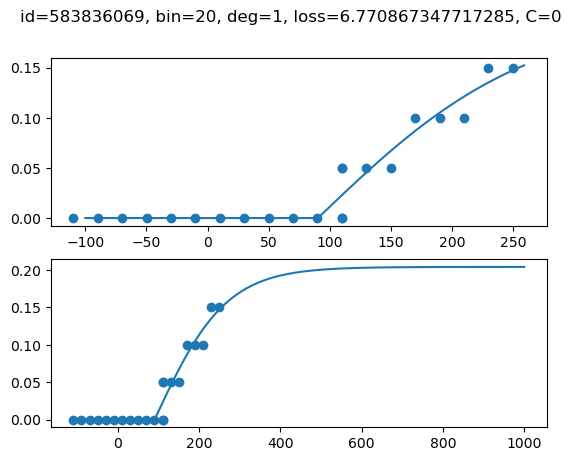

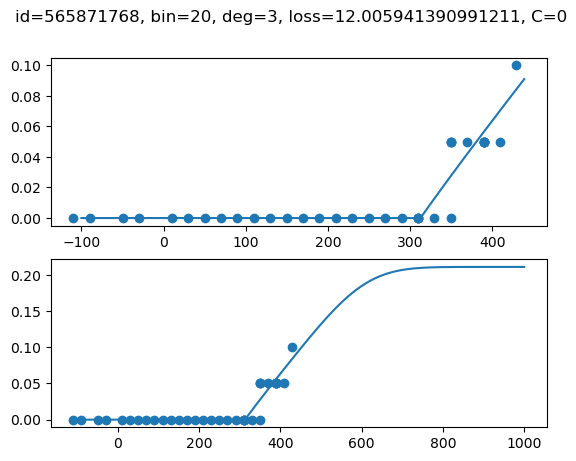

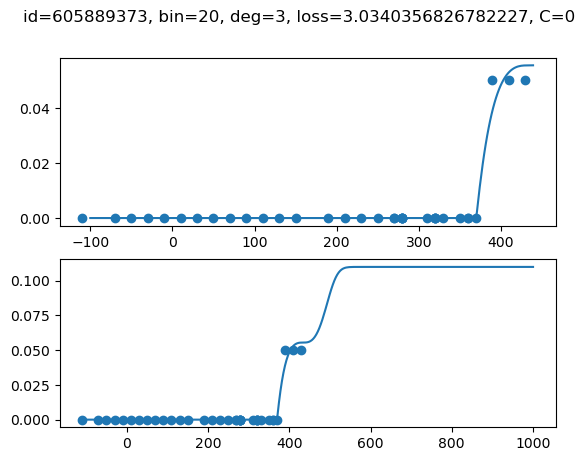

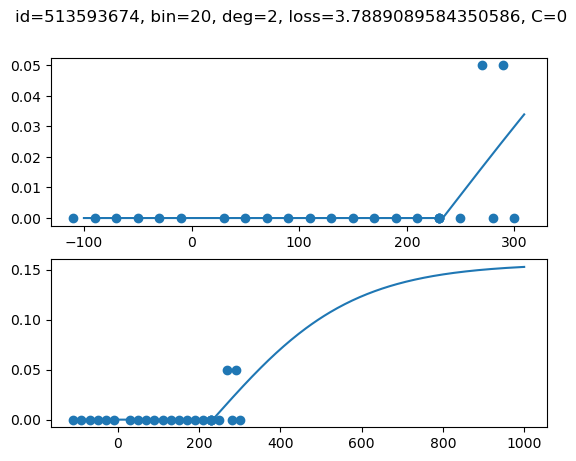

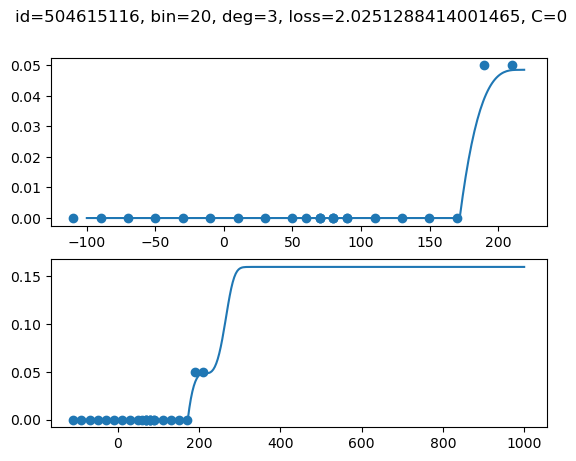

In [5]:
for cell_id in best_actvs:
    currents, firing_rates = preprocess_data(data, cell_id, bin_size=bin_size)
    Is = torch.tensor(currents)
    fs = torch.tensor(firing_rates)
    plot_activation(Is, fs, best_actvs[cell_id], best_losses[cell_id])
    print(cell_id)
    for name, param in best_actvs[cell_id].named_parameters():
        if param.requires_grad:
            print(name, param.data)
    best_actvs[cell_id].save_params(f"model/activation/{loss_fn}/bin_size_{bin_size}/{cell_id}_{C}.pickle")
    plt.savefig(f"figures/activation/{loss_fn}/bin_size_{bin_size}/{cell_id}_{C}_best.png")